# Lesson 2: Machine Learning Tree Methods

## Recap Lesson 1

Last month, we trained a linear model, but it didn't go so great. This time, we'll build off of last week's code and learn how to use tree-based machine learning models to predict future values of a stock's price. then, we'll go over how to use forest-based machine learning methods for regression and feature selection.

First, let's load last week's code:

In [60]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install TA-Lib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid


lng_df = pd.read_csv('data/lng.csv')
spy_df = pd.read_csv('data/spy.csv')

# Change index for Lesson 2
lng_df.set_index('Date', inplace=True)
lng_df.index = pd.to_datetime(lng_df.index)

spy_df.set_index('Date', inplace=True)
spy_df.index = pd.to_datetime(spy_df.index)


# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]


# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df.dropna()[feature_names]
targets = lng_df.dropna()['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(train_targets)

Date
2017-01-31    0.003358
2017-02-01    0.019321
2017-02-02   -0.002838
2017-02-03   -0.010115
2017-02-06   -0.007423
                ...   
2018-01-22    0.065896
2018-01-23   -0.002974
2018-01-24   -0.023143
2018-01-25   -0.015819
2018-01-26   -0.066344
Name: 5d_close_future_pct, Length: 250, dtype: float64


## Feature Engineering from volume

We're going to use non-linear models to make more accurate predictions. With linear models, features must be linearly correlated to the target. Other machine learning models can combine features in non-linear ways. For example, what if the price goes up when the moving average of price is going up, and the moving average of volume is going down? The only way to capture those interactions is to either multiply the features, or to use a machine learning algorithm that can handle non-linearity (e.g. random forests).

To incorporate more information that may interact with other features, we can add in weakly-correlated features. First we will add volume data, which we already have in the `lng_df` as the `Adj Volume` column.

Before we begin, remember that for TA-Lib functions (like `SMA()`), we will need to provide Numypy arrays, (i.e. `.values`) *not* the pandas DataFrame itself.

### Instructions
* Create a 1-day percent change in volume (using `pct_change()` from pandas), and assign it to the `Adj_Volume_1d_change` column in `lng_df`.
* Create a 5-day moving average of the 1-day percent change in Volume, and assign it to the `Adj_Volume_1d_change_SMA` column in `lng_df`.
* Plot histograms of these two new features we created using the `new_features` list.

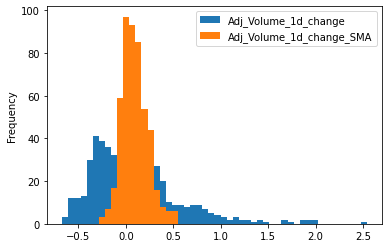

In [61]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values,
                        timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

Nice work! We can see the moving average of volume changes has a much smaller range than the raw data.

## Create day-of-week features

We can engineer datetime features to add even more information for our non-linear models. Most financial data has datetimes, which have lots of information in them – year, month, day, and sometimes hour, minute, and second. But we can also get the day of the week, and things like the quarter of the year, or the elapsed time since some event (e.g. earnings reports).

We are only going to get the day of the week here, since our dataset doesn't go back very far in time. The `dayofweek` property from the pandas datetime index will help us get the day of the week. Then we will dummy `dayofweek` with pandas' `get_dummies()`. This creates columns for each day of the week with binary values (0 or 1). We drop the first column because it can be inferred from the others.

### Instructions
* Use the `dayofweek` property from the `lng_df` index to get the days of the week.
* Use the `get_dummies()` function on the days of the week variable, giving it a prefix of `weekday`.
* Set the index of the `days_of_week` variable to be the same as the `lng_df` index so we can merge the two.
* Concatenate the `lng_df` and `days_of_week` DataFrames into one DataFrame.

In [62]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)
# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe

lng_df = pd.concat([lng_df, days_of_week], axis=1)
# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place

Good work engineering new features! Let's see how the correlate to the target.

## Examine correlations of the new features
Now that we have our volume and datetime features, we want to check the correlations between our new features (stored in the `new_features` list) and the target (`5d_close_future_pct`) to see how strongly they are related. Recall pandas has the built-in `.corr()` method for DataFrames, and seaborn has a nice `heatmap()` function to show the correlations.

### Instructions
* Extend our `new features` variable to contain the weekday's column names, such as `weekday_1`, by concatenating the weekday number with the `'weekday_'` string.
* Use Seaborn's `heatmap` to plot the correlations of `new_features` and the target, `5d_close_future_pct`.

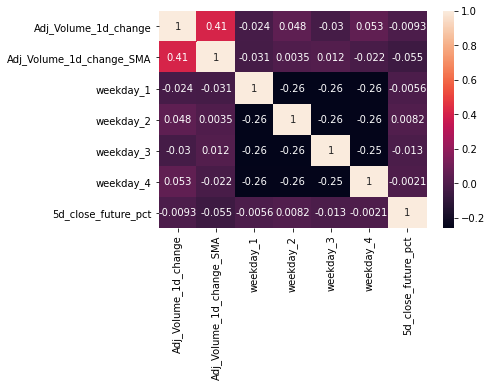

In [63]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.show()

Nice job! Even though the correlations are weak, they may improve our predictions via interactions with other features.

## Fit a decision tree
Random forests are a go-to model for predictions; they work well out of the box. But we'll first learn the building block of random forests -- decision trees.

Decision trees split the data into groups based on the features. Decision trees start with a root node, and split the data down until we reach leaf nodes

![title](img/basic_decision_tree.jpg)

We can use `sklearn` to fit a decision tree with `DecisionTreeRegressor` and `.fit(features, targets)`.

Without limiting the tree's depth (or height), it will keep splitting the data until each leaf has 1 sample in it, which is the epitome of overfitting. We'll learn more about overfitting in the coming chapters.

### Instructions
* Use the imported class `DecisionTreeRegressor` with default arguments (i.e. no arguments) to create a decision tree model called `decision_tree`.
* Fit the model using `train_features` and `train_targets` which we've created earlier (and now contain day-of-week and volume features).
* Print the score on the training features and targets, as well as `test_features` and `test_targets`.

In [64]:
# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

train_features = lng_df[feature_names].iloc[:250]
test_features = lng_df[feature_names].iloc[250:]

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))


1.0
-1.9061290005938853


A perfect fit! ...on the training data.

## Try different max depths
We always want to optimize our machine learning models to make the best predictions possible. We can do this by tuning hyperparameters, which are settings for our models. We will see in more detail how these are useful in future chapters, but for now think of them as knobs we can turn to tune our predictions to be as good as possible.

For regular decision trees, probably the most important hyperparameter is `max_depth`. This limits the number of splits in a decision tree. Let's find the best value of `max_depth` based on the R^2 score of our model on the test set, which we can obtain using the `score()` method of our decision tree models.

### Instructions
* Loop through the values 3, 5, and 10 for use as the `max_depth` parameter in our decision tree model.
* Set the `max_depth` parameter in our `DecisionTreeRegressor` to be equal to `d` in each loop iteration.
* print the model's score on the `train_features` and `train_targets`.

In [65]:
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets), '\n')
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.313332035717818 

-0.30706922103784007 

max_depth= 5
0.5117261722974892 

-0.7661362723397169 

max_depth= 10
0.8989892189602487 

-1.5887997465151984 



Great work! Remember that a `max_depth` of 3 got the best test score.

## Check our Results
Once we have an optimized model, we want to check how it is performing in more detail. We already saw the R^2 score, but it can be helpful to see the predictions plotted vs actual values. We can use the `.predict()` method of our decision tree model to get predictions on the train and test sets.

Ideally, we want to see diagonal lines from the lower left to the upper right. However, due to the simplicity of decisions trees, our model is not going to do well on the test set. But it will do well on the train set.

### Instructions
* Create a `DecisionTreeRegressor` model called `decision_tree` using 3 for the `max_depth` hyperparameter
* Make predictions on the train and test sets (`train_features` and `test_features`) with our decision tree model.
* Scatter and train the test predictions vs the actual target values with `plt.scatter()`, and set the `label` argument equal to `test` for the test set.

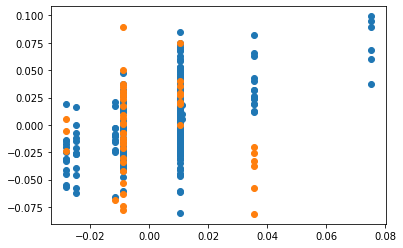

In [66]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

Nice work! The predictions group into lines because our depth is limited.

## Fit a Random Forest

Random Forest Models are a popular type of Machine Learning strategy. They perform well out of the box, and have lots of settings to optimize performance. Random forests can be used for classification or regression; we'll use it for regression to predict the future price change of LNG.

We'll create and fit the random forest model similarly to the decision trees using the `.fit(features, targets)` method. With `sklearn`'s `RandomForestRegressor`, there's a built-in `.score()` method we can use to evaluate performance. This takes arguments (`features`, `targets`), and returns the R^2 score (the coefficient of determination).


### Instructions
* Create the reandom forest model with the imported `RandomForestRegressor` class
* Fit (train) the random forest using `train_features` and `train_targets`.
* Print out the R^2 score on the train and test sets

In [67]:
# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9007872175890405
-0.09440894675296518


Nice work! Now let's tune the hyperparameters for better performance.

## Tune Random Forest Hyperparameters

As with all models, we want to optimize performance by tuning hyperparameters. We have many hyperparameters for random forests, but the most important is often the number of features we sample at each split, or `max_features` in `RandomForestRegressor` from the sklearn library. For models like random forests that have randomness built-in, we also want to set the `random_state`. This is set for our results to be reproducible.

Usually, we can use sklearn's `GridSearchCV()` method to search hyperparameters, but with a financial time series, we don't want to do cross-validation due to data mixing. We want to fit our models on the oldest data and evaluate on the newest data. So we'll use sklearn's `ParameterGrid` to create combinations of hyperparameters to search.

### Instructions
* Set the `n_estimators` hyperparameter to be a list with one value (200) in the `grid` dictionary.
* Set the `max_features` hyperparameter to be a list containing 4 and 8 in the `grid` dictionary.
* Fit the random forest regressor model (`rfr`, already created for you) to the `train_features` and `train_targets` with each combination of hyperparameters, g, in the loop.
* Calculate R2 by using `rfr.score()` on `test_features` and append the result to the `test_scores` list.

In [68]:
# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.0473317042742849 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


Good work! Our test Score (R^2) isn't great, but at least it's now greater than 0!

## Evaluate Performance
Lastly, and as always, we want to evaluate performance of our best model to check how well or poorly we are doing. Ideally it's best to do back-testing, but that's an involved process we don't have room to cover in this course.

We've already seen the R^2 scores, but let's take a look at the scatter plot of predictions vs actual results using `matplotlib`. Perfect predictions would be a diagonal line from the lower left to the upper right.

### Instructions
* Use the best number for `max_features` in our `RandomForestRegressor` (`rfr`) that we found in the previous exercise (it was 4).
* Make predictions using the model with the `train_features` and `test_features`.
* Scatter actual targets (`train_targets`/`test_targets`) vs the predictions (`train_predictions`/`test_predictions`), and label the datasets `train` and `test`.

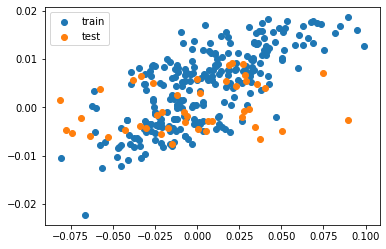

In [69]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

Great work! We can see our train predictions are good, but test predictions (generalization) are not great.

## Random Forest Feature Importances
One useful aspect of tree-based methods is the ability to extract feature importances. This is a quantitative way to measure how much each feature contributes to our predictions. It can help us focus on our best features, possibly enhancing or tuning them, and can also help us get rid of useless features that may be cluttering up our model.

Tree models in `sklearn` have a `.feature_importances_` property that's accessible after fitting the model. This stores the feature importance scores. We need to get the indices of the sorted feature importances using `np.argsort()` in order to make a nice-looking bar plot of feature importances (sorted from greatest to least importance).

### Instructions
* Use the `feature_importances` property of our random forest model (`rfr`) to extract feature importances into the `importances` variable.
* Use `numpy`'s argsort to get indicies of the feature importances from greatest to least, and save the sorted indicies in the `sorted_index` variable
* Set xtick labels to be feature names in the `labels` variable, using the `sorted_index` list. feature_names must be converted to a numpy array so we can index it with the `sorted_index` list.

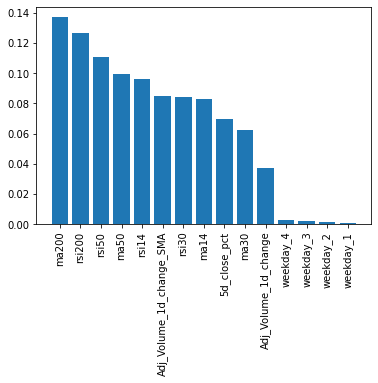

In [70]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

Great work! Unsurprisingly, it looks like the days of the week should be thrown out.

## A Gradient Boosting Model
Now we'll fit a gradient boosting (GB) model. It's been said a linear model is like a Toyota Camry, and GB is like a Black Hawk helicopter. GB has potential to outperform random forests, but doesn't always do so. This is called the no free lunch theorem, meaning we should always try lots of different models for each problem.

GB is similar to random forest models, but the difference is that trees are built successively. With each iteration, the next tree fits the residual errors from the previous tree in order to improve the fit.

### Instructions
* Create a `GradientBoostingRegressor` object with the given hyperparameters
* Fit the `gbr` model to the `train_features` and `train_targets`.
* Print the scores for the training and test features and targets

In [71]:
# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.40765658572761587
0.03655855607216019


Good job! In this case the gradient boosting model isn't that much better than a random forest. After all, there is no such thing as a free lunch.

## Gradient boosting feature importances

As with random forests, we can extract feature importances from gradient boosting models to understand which features are the best predictors. Sometimes it's nice to try different tree-based models and look at the feature importances from all of them. This can help average out any peculiarities that may arise from one particular model.

The feature importances are stored as a `numpy` array in the `.feature_importances_ property` of the gradient boosting model. We'll need to get the sorted indices of the feature importances, using `np.argsort()`, in order to make a nice plot. We want the features from largest to smallest, so we will use Python's indexing to reverse the sorted importances like `feat_importances[::-1]`.

### Instructions
* Reverse the `sorted_index` variable to go from greatest to least using python indexing.
* Create the sorted feature labels list as `labels` by converting `feature_names` to a `numpy` array and indexing with `sorted_index`.
* Create a bar plot of the xticks, and `feature_importances` indexed with the `sorted_index` variable, and `labels` as the xtick labels.

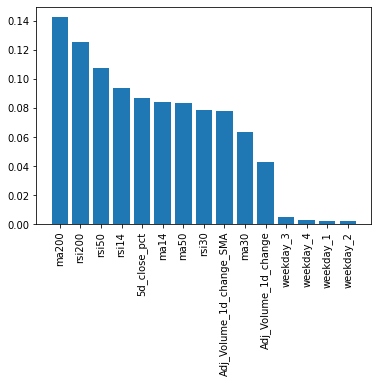

In [72]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
features = lng_df.dropna()[feature_names]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

Great job! Notice the feature importances are not exactly the same as the random forest model's...but they're close.